In [1]:
import torch      
from torch.autograd import Variable     
import torch.nn as nn 
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import cantera as ct
import csv

In [10]:
#data
# As a car company we collect this data from previous selling
# lets define car prices
car_prices_array = [3,4,5,6,7,8,9]
car_price_np = np.array(car_prices_array,dtype=np.float32)
car_price_np = car_price_np.reshape(-1,1)
car_price_tensor = Variable(torch.from_numpy(car_price_np))

# lets define number of car sell
number_of_car_sell_array = [ 7.5, 7, 6.5, 6.0, 5.5, 5.0, 4.5]
number_of_car_sell_np = np.array(number_of_car_sell_array,dtype=np.float32)
number_of_car_sell_np = number_of_car_sell_np.reshape(-1,1)
number_of_car_sell_tensor = Variable(torch.from_numpy(number_of_car_sell_np))

In [28]:
%%time
gas = ct.Solution('gri30.cti')
def f_x(T,phi):
    gas.TPX = T, ct.one_atm, 'CH4:%f,O2:1,N2:3.76'%(0.5*phi)
    r = ct.IdealGasConstPressureReactor(gas,energy = 'off')
    sim = ct.ReactorNet([r])
    return sim, r
file = open('data_output.csv', 'w')
csvfile = csv.writer(file)


states = ct.SolutionArray(gas, extra=['t'])
for phi in range(1,10,1):
    for T in range(1000,2000,100):
        phi_new = 0.5+0.15*phi
        sim, r = f_x(T,phi_new)
        time = 0.0
        for n in range(100):
            time +=1.e-5
            sim.advance(time)
            s = np.array([time, r.thermo.T, phi_new, r.thermo.X[gas.species_index('CH4')]])
            states.append(r.thermo.state, t = time)


            csvfile.writerow(s)
file.close()

Wall time: 1.51 s


In [11]:
# create class
class LinearRegression(nn.Module):
    def __init__(self,input_size,output_size):
        # super function. It inherits from nn.Module and we can access everythink in nn.Module
        super(LinearRegression,self).__init__()
        # Linear function.
        self.linear = nn.Linear(input_dim,output_dim)

    def forward(self,x):
        return self.linear(x)

In [12]:
input_dim = 1
output_dim = 1
model = LinearRegression(input_dim,output_dim) # input and output size are 1

In [13]:
mse = nn.MSELoss()

In [14]:
# Optimization (find parameters that minimize error)
learning_rate = 0.02   # how fast we reach best parameters
optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate)

In [15]:
# train model
loss_list = []
iteration_number = 1001
for iteration in range(iteration_number):
        
    # optimization
    optimizer.zero_grad() 
    
    # Forward to get output
    results = model(car_price_tensor)
    
    # Calculate Loss
    loss = mse(results, number_of_car_sell_tensor)
    
    # backward propagation
    loss.backward()
    
    # Updating parameters
    optimizer.step()
    
    # store loss
    loss_list.append(loss.data)
    
    # print loss
    if(iteration % 50 == 0):
        print('epoch {}, loss {}'.format(iteration, loss.data))


epoch 0, loss 25.51702880859375
epoch 50, loss 5.946239471435547
epoch 100, loss 4.018123626708984
epoch 150, loss 2.7152130603790283
epoch 200, loss 1.8347843885421753
epoch 250, loss 1.239840030670166
epoch 300, loss 0.8378117680549622
epoch 350, loss 0.566143810749054
epoch 400, loss 0.38256698846817017
epoch 450, loss 0.25851666927337646
epoch 500, loss 0.17468979954719543
epoch 550, loss 0.11804484575986862
epoch 600, loss 0.07976777851581573
epoch 650, loss 0.053902678191661835
epoch 700, loss 0.03642459213733673
epoch 750, loss 0.02461354248225689
epoch 800, loss 0.016632601618766785
epoch 850, loss 0.011239279992878437
epoch 900, loss 0.007594919763505459
epoch 950, loss 0.005132205784320831
epoch 1000, loss 0.003468053648248315


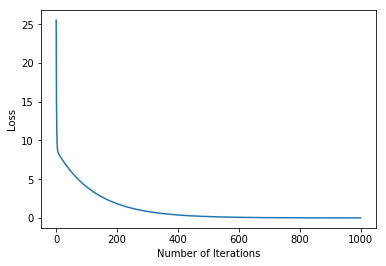

In [18]:
plt.plot(range(iteration_number),loss_list)
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.show()